<a href="https://colab.research.google.com/github/Shaik-Shehanaz30/Image_Caption_Generator/blob/main/Image_Caption_Generator_Flickr_Dataset_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [ ]:
!pip install tensorflow

In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
%cd /content/gdrive/MyDrive/Mini_Project

/content/gdrive/MyDrive/Mini_Project


In [ ]:
%cd /content/gdrive/MyDrive/Mini_Project/archive (5)

/content/gdrive/MyDrive/Mini_Project/archive (5)


In [ ]:
import os
if not os.path.isdir("Images"):
  os.makedirs("Images")

In [ ]:
BASE_DIR = '/content/gdrive/My Drive/Mini_Project/archive (5)'
WORKING_DIR = '/content/gdrive/My Drive/Mini_Project'


In [ ]:
import os

BASE_DIR = "/content/gdrive/My Drive/Mini_Project/archive (5)"
directory = os.path.join(BASE_DIR, "Images")

print("BASE_DIR exists:", os.path.exists(BASE_DIR))
print("directory exists:", os.path.exists(directory))


BASE_DIR exists: True
directory exists: True


## Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [ ]:
BASE1_DIR = '/content/gdrive/My Drive/Mini_Project/archive (5)'

In [ ]:
with open(os.path.join(BASE1_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

## Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

## Train Test Split

In [ ]:


# Ensure features[key] shape is (4096,)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = list(), list(), list()
        n = 0
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key])  # Ensure features[key] is (4096,)
                    X2.append(in_seq)
                    y.append(out_seq)

            if len(X1) == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()


In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1 = np.empty((batch_size, 4096))  # Pre-allocate feature memory
        X2 = np.empty((batch_size, max_length))  # Pre-allocate text sequence memory
        y = np.empty((batch_size, vocab_size))  # Pre-allocate label memory
        n = 0

        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1[n] = features[key]  # Store image features
                    X2[n] = in_seq
                    y[n] = out_seq
                    n += 1

                    if n == batch_size:  # Yield batch
                        yield {"image": X1, "text": X2}, y
                        n = 0  # Reset counter


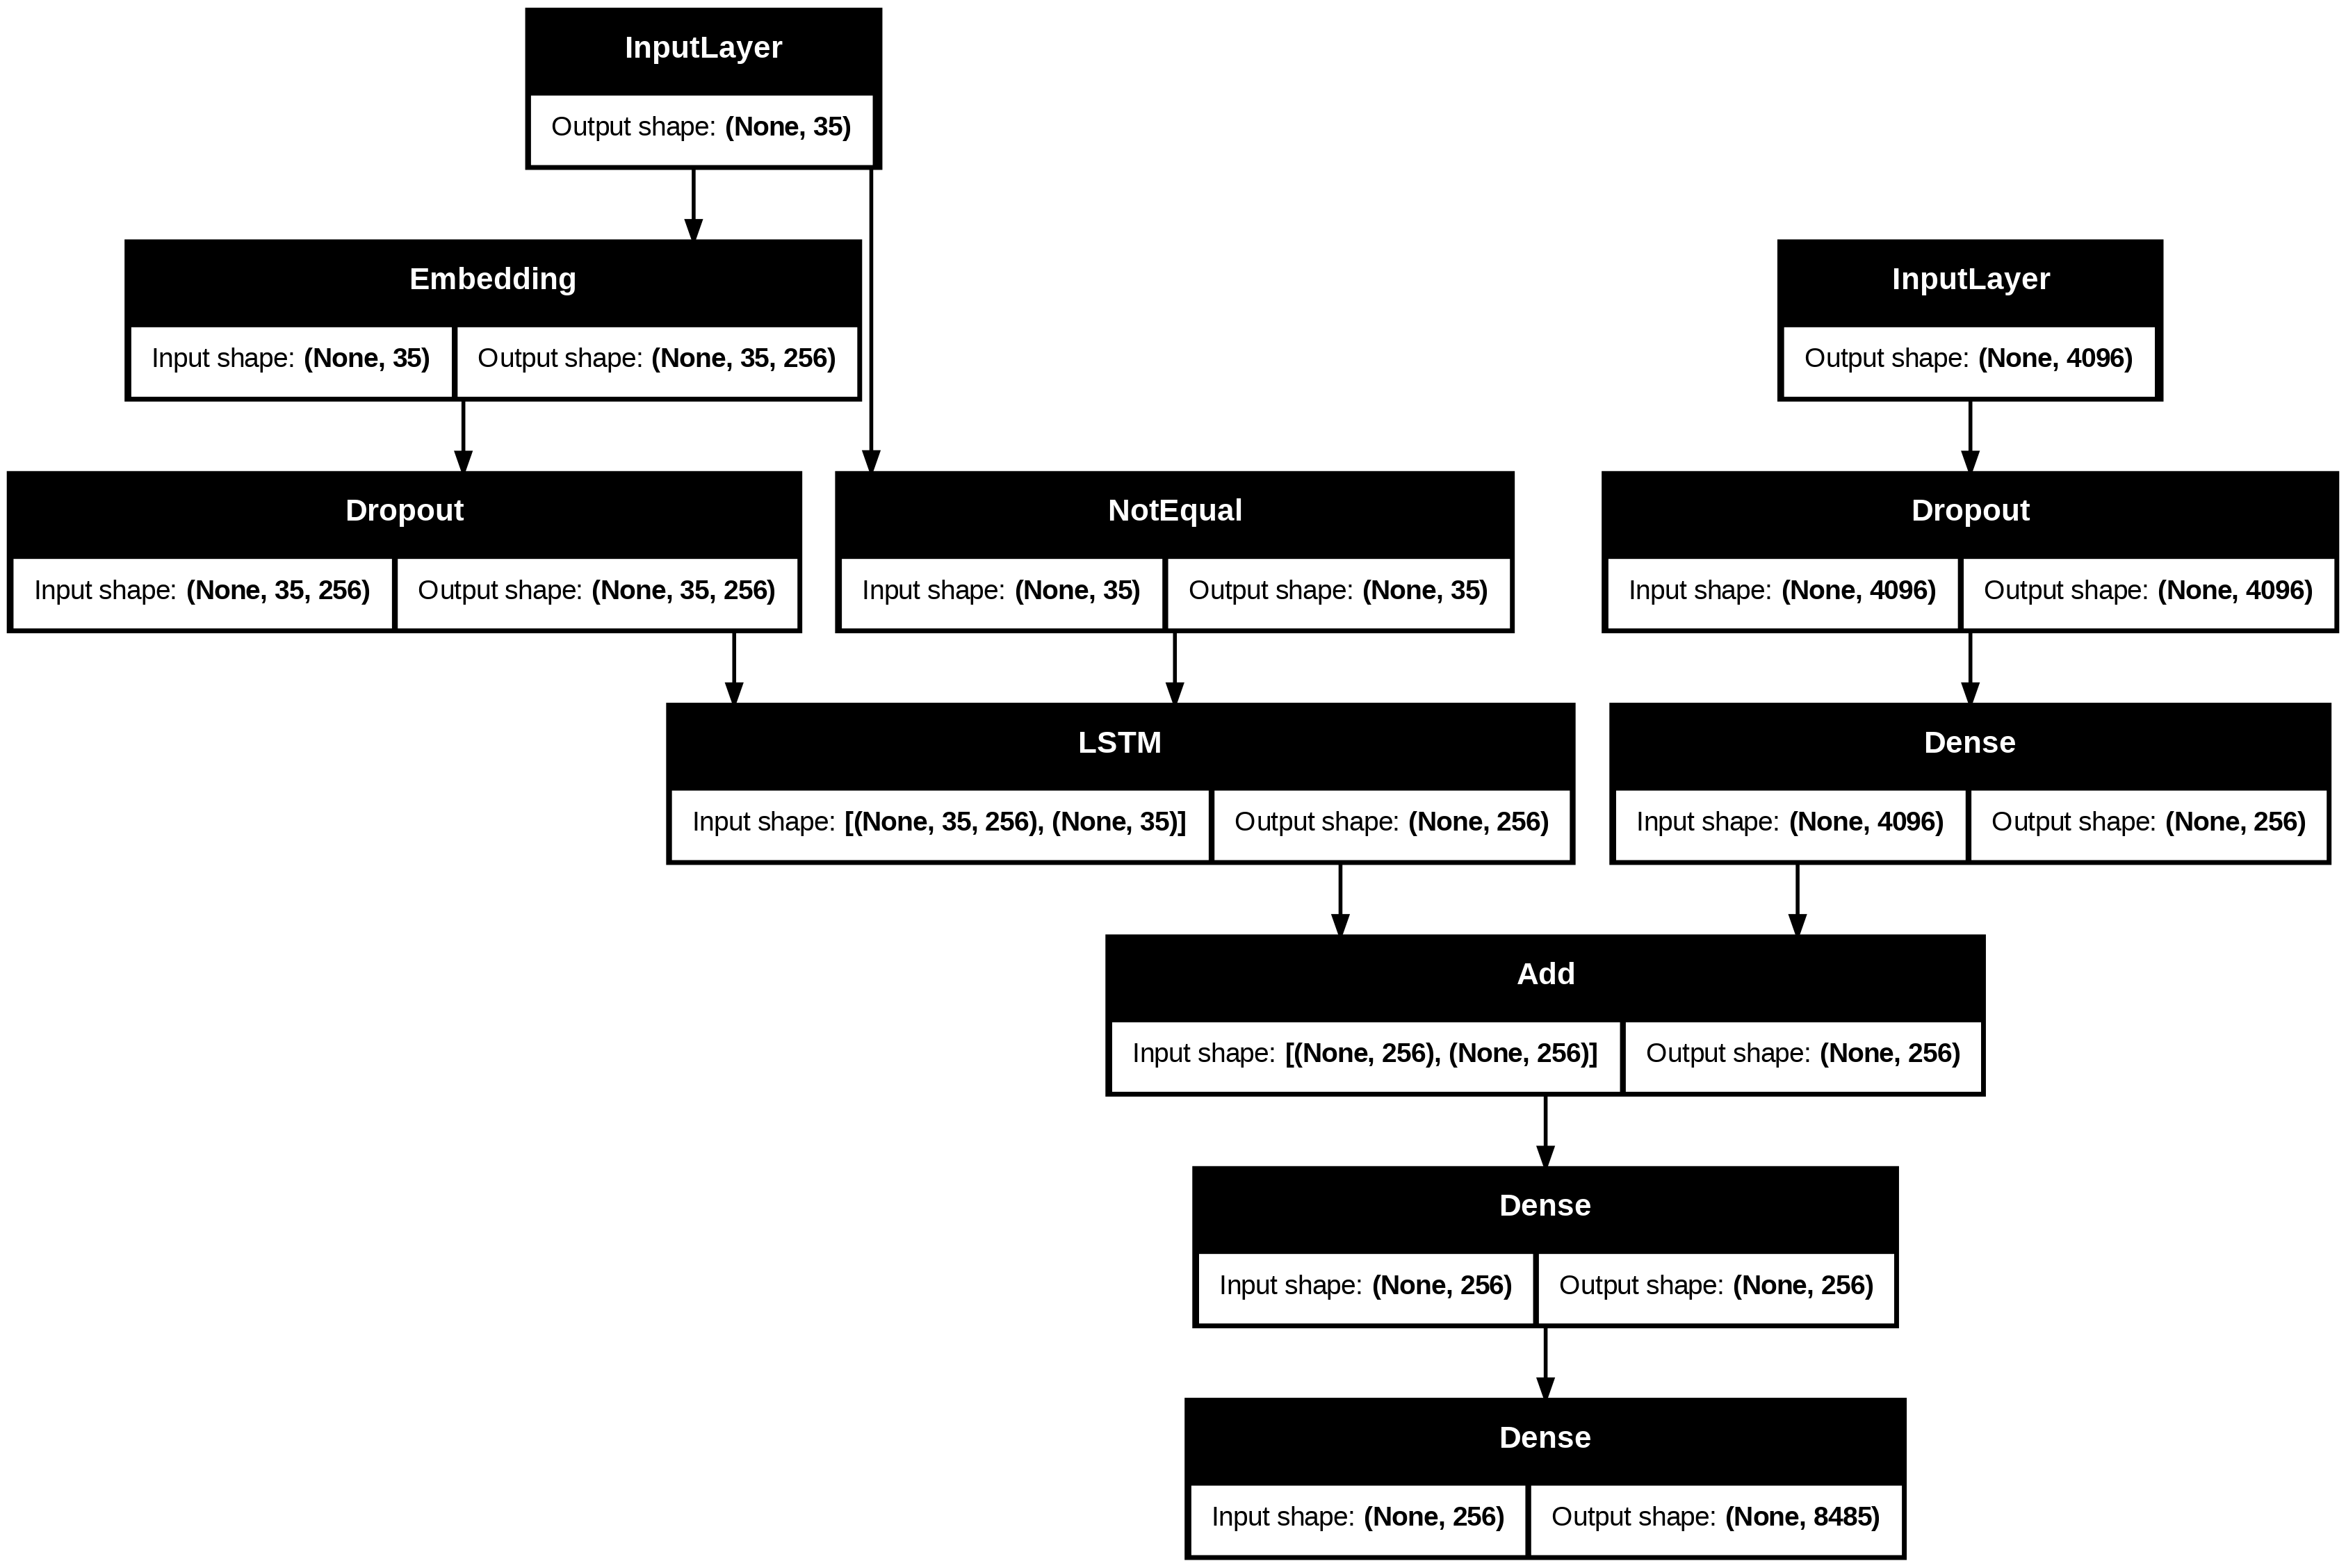

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
#se3 = LSTM(256)(se2)
se3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', unroll=True)(se2)


# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [ ]:
# Training parameters
epochs = 20
batch_size = 4
steps = len(train) // batch_size

# Train the model
for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1820/1820 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 6.2726
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.8390
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.5163
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.5505
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.0440
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.4234
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.1623
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.1365
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.6778
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 5.1977
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.1225
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.2806
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.4750
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.6591
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.9511
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.8496
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.34

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

## Model Creation

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.367305
BLEU-2: 0.141133


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Get the actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        # Clean the actual captions
        clean_caption = caption.replace("startseq ", "").replace(" endseq", "")
        print(clean_caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    # Clean the predicted caption
    clean_predicted_caption = y_pred.replace("startseq ", "").replace(" endseq", "")

    print('--------------------Predicted--------------------')
    print(clean_predicted_caption)

    # Display the image
    plt.imshow(image)


---------------------Actual---------------------
black dog and spotted dog are fighting
black dog and tri-colored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road
two dogs on pavement moving toward each other
--------------------Predicted--------------------
black and white dog and other on road


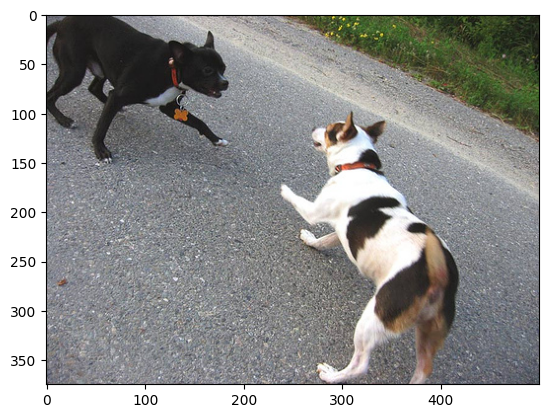

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass
--------------------Predicted--------------------
woman in blue helmet is


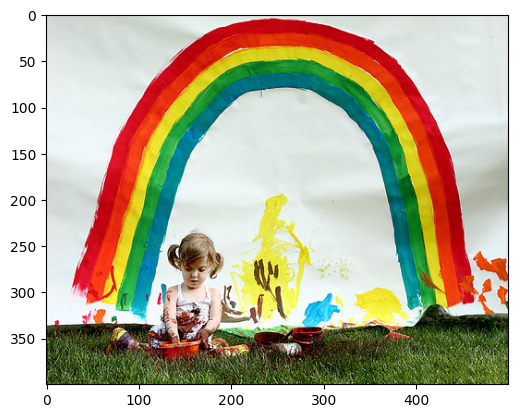

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
man in hat is displaying pictures next to skier in blue hat
man skis past another man displaying paintings in the snow
person wearing skis looking at framed pictures set up in the snow
skier looks at framed pictures in the snow next to trees
man on skis looking at artwork for sale in the snow
--------------------Predicted--------------------
woman in blue helmet is


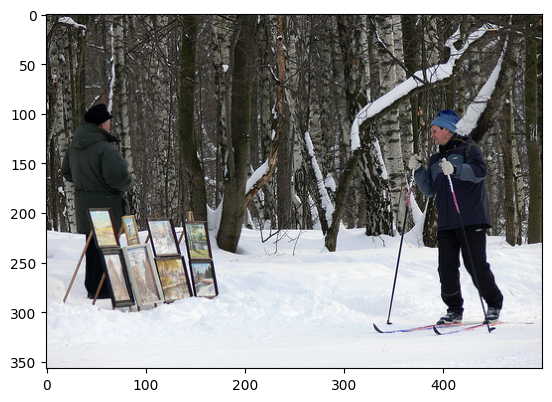

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

## Test with Real Image

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dog.jpeg to dog (1).jpeg


In [ ]:
# Process the image and extract features
image_path = "dog.jpeg"
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)

# Predict and clean the caption
caption_with_tokens = predict_caption(model, feature, tokenizer, max_length)
clean_caption = caption_with_tokens.replace("startseq ", "").replace(" endseq", "")

# Output the cleaned caption
print(clean_caption)


the the the the the the white and white dog is running through the the the the the the the the the the the the the the the the the the the the the the
